In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import sys
sys.path.insert(0, '.')
sys.path.insert(0, '..')

In [ ]:
# from food2vec.utils_dep import *
from food2vec.dataprep import DataLoader

In [13]:
import yaml

with open("../food2vec/settings.yml", "rb") as yaml_to_read:
    yml = yaml.safe_load(yaml_to_read)

# Constants

In [8]:
from glob import glob

In [9]:
yml_path = glob(os.path.join(yml['base_dir'], 'food2vec', '*.yml'))[0]
yml_path

'../food2vec/settings.yml'

In [10]:
filepath = os.path.join(yml['base_dir'], yml['data_dir'], yml['train_data'])
label_colname = yml['label_col']
ingrd_colname = yml['ingrd_col']
batch_size = yml['batch_size']
max_window_size = yml['max_window_size']
num_noise_words = yml['num_noise_words']

# Getting w2v train data

In [11]:
dl = DataLoader()
df, texts, labels = dl.get_texts_labels(filepath, label_colname, ingrd_colname)
data_iter, vocab = dl.dataloader(texts, batch_size, max_window_size, num_noise_words)

# Train word vectors (food ingredient vectors)

In [192]:
from mxnet import autograd, gluon, np, npx 
from mxnet.gluon import nn
npx.set_np()

In [193]:
# loss function
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

In [194]:
# initialize model parameters
embed_size = 100 
net = nn.Sequential() 
net.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size), 
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size))

In [195]:
TrainUtils.set_npx(npx)

loss 0.0008515581933855034, 4940.243731390927 tokens/sec on cpu(0)


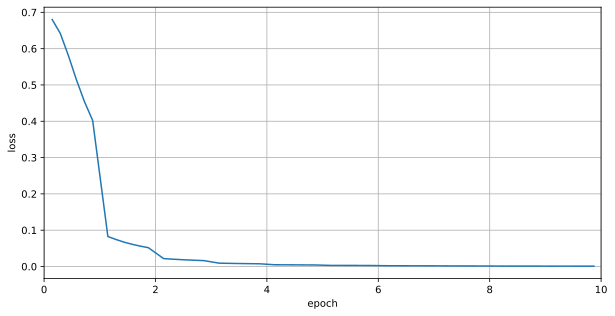

In [196]:
TrainUtils.train(net, data_iter, loss)

In [ ]:
# TrainUtils.get_similar_tokens('milk', 3, vocab)

# Get Food Vectors

In [14]:
filepath = os.path.join(yml['base_dir'], yml['data_dir'], yml['train_data'])
label_colname = yml['label_col']
ingrd_colname = yml['ingrd_col']
df = pd.read_csv(filepath)
df = df.loc[df[label_colname].notnull(),]
df = df.loc[df[ingrd_colname].notnull(),]
texts = list(df[ingrd_colname].values)
labels = list(df[label_colname].values)

In [6]:
embed = TrainUtils.load_pretrained()

In [14]:
embed.get('salt')

array([-6.8930e-01,  7.3925e-01, -4.4262e-01, -2.2748e-01, -4.0559e-02,
        7.6234e-02,  3.3102e-01,  9.6410e-01, -2.7412e-01, -7.3146e-04,
        3.2516e-01,  5.4533e-04, -1.8605e-01,  2.6008e-01, -6.9010e-01,
       -4.5958e-01, -1.0315e-01, -5.3203e-01, -9.3095e-01, -8.7926e-02,
       -1.1651e+00,  7.8851e-01, -3.9112e-01,  4.0990e-01, -6.8115e-01,
        1.2812e+00, -1.2618e-01, -1.1121e-01,  3.0938e-02,  2.5558e-01,
        5.4892e-03,  3.8280e-01, -2.5929e-01, -2.1966e-01, -2.5036e-01,
        6.6442e-02,  1.5813e-01,  8.7148e-01,  6.0061e-02, -9.1280e-02,
       -1.9248e-01, -2.2457e+00, -7.9675e-01, -1.2362e+00,  5.8526e-01,
        5.5414e-01, -1.8113e-01, -5.3970e-01,  2.7283e-02, -2.7610e-01,
       -3.3407e-01,  9.1553e-02,  1.7698e-01,  8.2703e-01, -1.0792e+00,
       -1.4221e+00, -9.5252e-01, -2.9515e-01,  1.1913e+00, -1.3648e-01,
       -5.7573e-01,  3.9100e-01,  2.8239e-01,  2.3132e-01,  1.2008e+00,
       -1.1684e+00,  9.9435e-01, -6.9629e-01,  5.8286e-02, -5.22

In [15]:
food_vec = TrainUtils.get_food_vectors(texts, embed)

In [219]:
print(TrainUtils.find_food_index(labels, 'Pepsi Zero Sugar Soda - 6pk / 16.9 Fl Oz'))
print(TrainUtils.find_food_index(labels, 'Pepsi Diet Cola Soda 16.9oz, 6pk'))
print(TrainUtils.find_food_index(labels, 'Salad Dressing Asian'))

977
1003
289


### Similarity betweek two kinds of Pepsi

In [214]:
TrainUtils.calc_cosine_similarity(food_vec[977], food_vec[1003])

array([0.979011])

### Similarity between Pepsi and Salad Dressing

In [221]:
TrainUtils.calc_cosine_similarity(food_vec[977], food_vec[289])

array([0.75686623])

In [220]:
TrainUtils.calc_cosine_similarity(food_vec[1003], food_vec[289])

array([0.75733211])

## Find the most similar food

In [261]:
def find_similar_food(query_token_index, food_vectors, labels, topn=5):
    query_vec = food_vectors[query_token_index]
    similarity_scores = {}
    for i, food in enumerate(food_vectors):
        if i != query_token_index:
            similarity_scores[i] = TrainUtils.calc_cosine_similarity(query_vec, food)[0]
    # sort by similarity score
    sorted_scores = {k: v for k, v in sorted(similarity_scores.items(), key=lambda item: item[1])}
    indx1 = list(sorted_scores)[-topn:]
    indx2 = list(sorted_scores)[:topn]
    most_similar = []
    least_similar = []
    for id in indx1:
        most_similar.append(labels[id])
    for id in indx2:
        least_similar.append(labels[id])
    return sorted_scores, most_similar, least_similar

### Most similar foods to: "Pepsi Zero Sugar Soda"

In [269]:
print(TrainUtils.find_food_index(labels, 'Pepsi Zero Sugar Soda - 6pk / 16.9 Fl Oz'))

977


In [262]:
sorted_scores, most_similar, least_similar = find_similar_food(977, food_vec, labels)

In [263]:
print("Most similar: ")
print("-"*15)
print(", \n".join(most_similar))
print("="*50)
print("Least similar: ")
print("-"*15)
print(", \n".join(least_similar))

Most similar: 
---------------
Diet Rite Cola, 12 fl oz, 
Diet Canada Dry Ginger Ale 2 L, 
Diet Canada Dry Ginger Ale 20 Oz, 
Pepsi Zero Sugar Soda 12oz 12pk, 
Cola Invigorating Diet
Least similar: 
---------------
Shimabara Tenobe Somen Shimakumo ï¿½ï¿½ï¿½tï¿½ï¿½ï¿½ï¿½ï¿½, 
10 Oz All Natural Timothy Hay, 
Dark Mint Organic Chocolate Bar, 
Twinings English Afternoon Tea, 
Vanilla Tootsie Roll Midgees Limited Edition 12 Ounce Bag


***

# draft

In [17]:
TrainUtils.calc_cosine_similarity(food_vec[977], food_vec[1003])

array([0.90933677])

In [19]:
from scipy.spatial.distance import cosine

In [20]:
1 - cosine(food_vec[977], food_vec[1003])

0.9093367713095127

In [21]:
import numpy as np
embeddings_index = {}
f = open(os.path.join('..', 'models', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embed = embeddings_index

food_vec_glove = []
for item in texts_:
    cnt = 1
    foodvec = np.zeros(100)
    ingrds = item.split(',')
    for ingrd in ingrds:
        ingrd_ = ingrd.split(' ')
        for e in ingrd_:
            try:
                foodvec += embed[e]
                cnt += 1
            except KeyError:
                pass
    foodvec /= cnt
    food_vec_glove.append(foodvec)

In [145]:
vec1 = food_vec_glove[977]
vec2 = food_vec_glove[1003]
vec3 = food_vec_glove[289]

In [146]:
v1 = vec1[:,np.newaxis]
v2 = vec2[:,np.newaxis]
v3 = vec3[:,np.newaxis]

In [150]:
cosine_measure(v1, v2)

array([0.979011])

In [151]:
cosine_measure(v1, v3)

array([0.75686623])

## Find the most similar food

In [257]:
def find_similar_food(query_token_index, food_vectors, labels, topn=5):
    query_vec = food_vectors[query_token_index]
    similarity_scores = {}
    for i, food in enumerate(food_vectors):
        if i != query_token_index:
            similarity_scores[i] = TrainUtils.calc_cosine_similarity(query_vec, food)[0]
    # sort by similarity score
    sorted_scores = {k: v for k, v in sorted(similarity_scores.items(), key=lambda item: item[1])}
    indx1 = list(sorted_scores)[-topn:]
    indx2 = list(sorted_scores)[:topn]
    most_similar = []
    least_similar = []
    for id in indx1:
        most_similar.append(labels[id])
    for id in indx2:
        least_similar.append(labels[id])
    return sorted_scores, most_similar, least_similar

In [259]:
sorted_scores, most_similar, least_similar = find_similar_food(977, food_vec, labels)

Most similar: 
Diet Rite Cola, 12 fl oz, 
Diet Canada Dry Ginger Ale 2 L, 
Diet Canada Dry Ginger Ale 20 Oz, 
Pepsi Zero Sugar Soda 12oz 12pk, 
Cola Invigorating Diet
Least similar: 
Shimabara Tenobe Somen Shimakumo ï¿½ï¿½ï¿½tï¿½ï¿½ï¿½ï¿½ï¿½,10 Oz All Natural Timothy Hay,Dark Mint Organic Chocolate Bar,Twinings English Afternoon Tea,Vanilla Tootsie Roll Midgees Limited Edition 12 Ounce Bag


In [260]:
print("Most similar: ")
print("-"*15)
print(", \n".join(most_similar))
print("="*50)
print("Least similar: ")
print("-"*15)
print(", \n".join(least_similar))

Most similar: 
---------------
Diet Rite Cola, 12 fl oz, 
Diet Canada Dry Ginger Ale 2 L, 
Diet Canada Dry Ginger Ale 20 Oz, 
Pepsi Zero Sugar Soda 12oz 12pk, 
Cola Invigorating Diet
Least similar: 
---------------
Shimabara Tenobe Somen Shimakumo ï¿½ï¿½ï¿½tï¿½ï¿½ï¿½ï¿½ï¿½, 
10 Oz All Natural Timothy Hay, 
Dark Mint Organic Chocolate Bar, 
Twinings English Afternoon Tea, 
Vanilla Tootsie Roll Midgees Limited Edition 12 Ounce Bag


## 7-11 Foods

In [222]:
recipes = pd.read_csv('../data/food_ingredients_711.csv')
recipes = recipes.loc[recipes["productname"].notnull(),]
recipes = recipes.loc[recipes["category"].notnull(),]

In [229]:
recipes.head()

OrderableUPC   productname category          brand  \
0   28498000425        Muffin  SNKCAKE  BROWNIE BAKER   
2   46704068403  Potato Skins  FRZNSNK    TGI FRIDAYS   
5   25600088944        Donuts  SNKCAKE      TASTYKAKE   
7   72220220315        Donuts  SNKCAKE          FRANZ   
8  674971538055       Squares  SNKCAKE   DANCING DEER   

                                         ingredients  
0  Sugar, Enriched Bleached Flour (Wheat Flour, F...  
2  Potato Skins (Potatoes, Water, Batter Mix, (Mo...  
5  Enriched Unbleached and Bleached Flour (Wheat ...  
7  Donut Mix: Enriched Bleached Wheat Flour (Whea...  
8  Unbleached Unbromated Wheat Flour (Wheat Flour...

In [230]:
labels_711 = list(recipes["productname"].values)
texts_raw_711 = list(recipes["ingredients"].values)

In [224]:
texts_711, topn_711 = W2VUtils.ingredient_cleanup(texts_raw_711)

In [232]:
texts_raw_711[1]

'Potato Skins (Potatoes, Water, Batter Mix, (Modified Potato Starch, Rice Flour, Degermed Yellow Corn Flour, Dextrin, Salt, Leavening [Sodium Acid Pyrophosphate, Sodium Bicarbonate], Onion Powder, Garlic Powder, Dextrose, Spices, Spice Extractive, Xanthan Gum], Soybean Oil), Cheddar Cheese (Cultured Milk, Salt, Enzymes, Annatto [Color]), Cheese Sauce (Water, Cheddar Cheese Powder (Whey, Modified Corn Starch, Natural Flavors, Cheddar [Cheese Cultured Milk, Salt, Enzymes], Salt, Maltodextrin, Contains Less than 2% of Disodium Phosphate, Cellulose Gum, Mono and Diglycerides, Lactic Acid, Spice [Contains Mustard], Yeast Extract, Guar Gum, Annatto Extract [Color], Butter [Cream, Salt], Buttermilk, Nonfat Milk, Silicon Dioxide, Soybean Oil), Applewood Smoked Bacon-Smoke Flavoring Added (Bacon Cured with Water, Salt, Sugar, Sodium Phosphate, Sodium Ascorbate, Sodium Nitrate, Smoke Flavor).'

In [225]:
texts_711[1]

'potatoskins,onionpowder,garlicpowder,dextrose,spice,spiceextractive,xanthangum,soybeanoil,cheddarcheese,cheesesauce,salt,maltodextrin,containslessdisodiumphosphate,cellulosegum,monodiglycerides,lacticacid,spice,yeastextract,guargum,annattoextract,butter,buttermilk,nonfatmilk,silicondioxide,soybeanoil,applewoodsmokedbaconsmokeflavoringadded'

In [233]:
labels_711[:100]

['Muffin',
 'Potato Skins',
 'Donuts',
 'Donuts',
 'Squares',
 "Donuts O's",
 'Mexican Casserole',
 'Pound Cake',
 'Bread',
 'Pie',
 'Angel Wings',
 'Bread',
 'Krimpets',
 'Cookies',
 'Flavored Pie',
 'Bread',
 'Crispy Wheels',
 'Cake',
 'Bread',
 'Sandwiches',
 'Pizza Rolls',
 'Brownie',
 'Cookies',
 'Pie',
 'Kandy Kakes',
 'Pizza',
 'Lunch Combinations',
 'Nutty Bars',
 'Kandy Bar Kakes',
 'Tortillas',
 'Tortillas',
 'Donuts',
 'Bagels',
 'Sandwich',
 'Bagels',
 'Sandwich',
 'Cream Cheese Cake',
 'Donuts',
 'Hamburger Buns',
 'Sweet Rolls',
 'Nutty Buddy',
 'Bread',
 'Rangoon',
 'Twinkies',
 'Kandy Kakes',
 'Bread',
 'Pizza',
 'Donuts',
 'Brownies',
 'Donuts',
 'Donuts',
 'Butter Cake',
 'Creme Pie',
 'Ciabatta',
 'Kandy Kakes',
 'Donuts',
 'Cupkakes',
 'Burger',
 'Cupkakes',
 'Cup Cakes',
 'Pesto Tortellini',
 'Bread',
 'Bread',
 'Mac & Cheese',
 'Bread',
 'Donuts',
 'Donuts',
 'Bulkie Rolls',
 'Bread',
 'Donuts',
 'Sandwiches',
 'Cookies',
 'Bread',
 'Fine Pastry',
 'Tortillas',
 '

In [264]:
food_vec_711 = TrainUtils.get_food_vectors(texts_711, embed)

In [265]:
labels_711.index('Pie')

9

In [266]:
sorted_scores711, most_similar711, least_similar711 = find_similar_food(9, food_vec_711, labels_711)

In [268]:
print("Most similar: ")
print("-"*15)
print(", \n".join(most_similar711))
print("="*50)
print("Least similar: ")
print("-"*15)
print(", \n".join(least_similar711))

Most similar: 
---------------
Kandy Kakes, 
Pie, 
Cakes, 
Kandy Kakes, 
Chocolate Bells
Least similar: 
---------------
Donuts, 
Tortillas, 
Hamburger Buns, 
Fine Pastry, 
Sweet Roll


# Check food similarity based on ingredients

In [136]:
def get_token_vector(query_token, embed):
    W = embed.weight.data()
    return W[vocab[query_token]]

embed = TrainUtils.net[0]
x = get_token_vector('milk', embed)
x

array([-0.21816538, -0.14865549, -0.1604876 , -0.15086272,  0.21541318,
        0.17497443,  0.23307128, -0.18137708,  0.20235102,  0.22733998,
        0.18195666, -0.11243937, -0.26510325, -0.1592522 ,  0.18397623,
        0.14955299,  0.21859407,  0.24521346,  0.20678677, -0.14930993,
        0.2825008 , -0.1956527 , -0.18640938,  0.21230398, -0.1677599 ,
        0.18324961, -0.22109625, -0.14140515,  0.29961324,  0.15556204,
        0.24728341,  0.14739977, -0.25243163, -0.2703065 , -0.264402  ,
       -0.3081819 , -0.26301372,  0.2647632 ,  0.18743587, -0.17495316,
       -0.25507516,  0.20992202,  0.25925496, -0.24831425, -0.13342063,
        0.19590865,  0.27310354,  0.20352648,  0.36640897,  0.22490227,
        0.25207424, -0.28283966, -0.29205003, -0.14497635,  0.29869008,
        0.11871687,  0.20838265,  0.30829358,  0.21828902, -0.2150019 ,
       -0.16596462,  0.3821323 ,  0.15992548, -0.19417866,  0.17258024,
        0.25195318, -0.1525397 , -0.17904434,  0.19071199, -0.24

In [139]:
embed = TrainUtils.net[0]

food_vec = []
for item in texts_:
    cnt = 1
    foodvec = np.zeros(100)
    ingrds = item.split(',')
    for ingrd in ingrds:
        foodvec += get_token_vector(ingrd, embed)
        cnt += 1
    foodvec /= cnt
    food_vec.append(foodvec)

AssertionError: Argument lhs must have NDArray type, but got [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

In [114]:
len(food_vec)

9971

In [218]:
print(labels.index('Pepsi Zero Sugar Soda - 6pk / 16.9 Fl Oz'))
print(labels.index('Pepsi Diet Cola Soda 16.9oz, 6pk'))
print(labels.index('Salad Dressing Asian'))

977
1003
289


In [140]:
# vec1 = food_vec[977]
# vec2 = food_vec[1003]
# vec3 = food_vec[289]

vec1 = food_vec_glove[977]
vec2 = food_vec_glove[1003]
vec3 = food_vec_glove[289]

In [141]:
v1 = vec1[:,np.newaxis]
v2 = vec2[:,np.newaxis]
v3 = vec3[:,np.newaxis]

In [149]:
import math

def dot_product(v1, v2):
    return sum(map(lambda x: x[0] * x[1], zip(v1, v2)))

def cosine_measure(v1, v2):
    prod = dot_product(v1, v2)
    len1 = math.sqrt(dot_product(v1, v1))
    len2 = math.sqrt(dot_product(v2, v2))
    return prod / (len1 * len2)

In [142]:
cosine1 = cosine_measure(v1, v2)
print(cosine)

[0.9994271]


In [143]:
cosine2 = cosine_measure(v2, v3)
print(cosine)

[0.9994271]


In [123]:
cosine1/cosine2

array([1.0005641])

In [66]:
texts_, topn_ingrd = W2VUtils.ingredient_cleanup(texts)
texts_[:10]

['dried prunes,water,corn syrup,sugar,pectin',
 'salt,sugar,molasses,spice,garlic onion,tapioca maltodextrin,bacon fat cooked bacon,silicon dioxide,autolyzed yeast,sunflower oil,corn maltodextrin,vinegar,extractives paprika,natural flavor',
 'salt,yellow  lake,tricalcium phosphate artificial butter flavor',
 'mechanically hulled seasame seedsallergy information packed facility processes wheat,flour,peanuts tree nuts,mechanically hulled seasame seedsallergy information packed facility processes wheat,flour,peanuts tree nuts',
 'false',
 'red raspberries,sugar,glucose syrup,citric acid,pectin contains wheat',
 'noodles wheat flour,water,wheat gluten,modified tapioca starch,salt,sodium alginate,lactic acid sauce packet sugar,water,soy sauce,plum sauce,rice vinegar,pineapple juice concentrate,salt,hydrolyzed soy protein,tomato paste,modified corn starch,orange juice concentrate,onion,yeast extract,red chili pepper vegetable packet ',
 'wheat flour,soybean oil,salt,dehydrated garlic,sugar,o

In [73]:
for i in texts_:
    print(i.split(','))
    break

['dried prunes', 'water', 'corn syrup', 'sugar', 'pectin']


In [74]:
get_token_vector('corn syrup', embed)

array([-0.29846767, -0.23851077, -0.2200646 , -0.19535759,  0.22913472,
        0.22827756,  0.17678437, -0.22265548,  0.20326182,  0.22604778,
        0.31963995, -0.17639276, -0.21955334, -0.20177625,  0.29799122,
        0.2757738 ,  0.18829602,  0.16593984,  0.27806857, -0.24436988,
        0.33372796, -0.17987789, -0.2615069 ,  0.2814041 , -0.24621712,
        0.21623787, -0.26653564, -0.19434749,  0.27922907,  0.22723372,
        0.28303176,  0.16507329, -0.18291646, -0.27364185, -0.2868997 ,
       -0.33775944, -0.2485854 ,  0.29894334,  0.25032732, -0.22032946,
       -0.17942514,  0.21559724,  0.25285617, -0.23661092, -0.18294649,
        0.2665073 ,  0.35279083,  0.2623008 ,  0.542126  ,  0.3011781 ,
        0.22762612, -0.33537382, -0.25659475, -0.21940736,  0.22604631,
        0.2112798 ,  0.21608056,  0.22580793,  0.2774557 , -0.27803433,
       -0.22451904,  0.42989308,  0.29392043, -0.29561353,  0.15924567,
        0.21597427, -0.17331228, -0.17530099,  0.2567398 , -0.26

In [102]:
list(df["name"].unique())

['Simon Fischer Fruit Bttr Prune Lekvar',
 'McCORMICK GRILL MATES MOLASSES BACON SEASONING 1 x 77g JAR AMERICAN IMPORT',
 'Jolly Time Popcorn',
 'Ziyad Tahini Sesame Sauce',
 'Fla-Vor-Ice Plus Giant Pops',
 'Hero Fruit Sprd Blk Currant-12 Oz -pack of 8',
 'Simply Asia Noodle Bowl Mandarin Orange -- 8.5 oz',
 'Italian Bread Crumbs',
 'BACK TO NATURE CEREAL ORANGE CRUNCH GRAN',
 'Nutrament Strawberry Complete Nutrition Drink 12 Fl. Oz. Can',
 'Kikkoman Original Pearl Organic Soymilk, 32oz',
 'Kikkoman Chocolate Pearl Organic Soymilk, 32 Fl Oz',
 'Blue Diamond Almondsï¿½ï¿½ Almond Breezeï¿½ï¿½ Chocolate Almondmilk 0.5 Gal. Carton',
 "Stella D'oro Roasted Garlic Breadsticks, 7.8 Oz",
 'Badia Anise Seed, .5 Oz',
 "Tone's Garlic Powder, 2.88 Oz",
 'Trolli Sour Brite Eggs, 4.0 Ounce Bags, (pack of 12)',
 'Cornnuts Ranch Bag',
 'Planters Pistachio Lovers Mix 18.5 Oz. Canister',
 'Bob Evansï¿½ï¿½ Tasteful Sidesï¿½ï¿½ï¿½ Macaroni & Cheese 28 Oz. Tray',
 'Ground Cumin',
 "Nature's Path Organic Lo

In [84]:
list(df.loc[df["manufacturer"] == 'Pepsi', "name"])

['Pretzel Rods, 10 oz (283.5 g)',
 'Pom Nectarine',
 'Aquafina Flavorsplashï¿½ï¿½ Really Raspberry Flavored Water 20 Fl. Oz. Bottle',
 'Green Tea',
 'Iced Tea',
 'Water Pure',
 'Pepsi Zero Sugar Soda - 6pk / 16.9 Fl Oz',
 'Pepsi Diet Cola Soda 16.9oz, 6pk',
 'Sobe Lifewater 0 Cal Strawberry Dragonfruit Vitamin Enriched Water 20 Oz',
 'Aquafinia Flavorsplash Go Flavored Water - 20oz',
 'Pepsi Next Cola, 12 Fl Oz',
 'Manzanita Sol Apple (12 - 12 Fluid Ounce) 144 Fluid Ounce 12 Pack Aluminum Can',
 'Root Beer',
 'Mugï¿½ï¿½ Diet Cream Soda Caffeine Free 2l Plastic Bottle',
 'Pepsi Cola 24 Fl Oz 6 Pk',
 'Pepsi Cola Caffeine Free Soda 12 Oz, 12 Pk',
 'Pepsi - 6pk/16 Fl Oz',
 'Pepsi Cola Soda 16.9 Oz, 6 Pk',
 'Mountain Dew 16 Oz 6 Pk',
 'StarbucksÂ® Caramel Coffee with Milk Medium Roast Iced Coffee 11 fl. oz. Bottle',
 'Rold Gold Waves Xl Cheddar 7.0 Oz',
 "Stacy's Pita Chips Multigrain, 7.33 OZ",
 'Pepsi Cola Caffeine Free Soda 2 L',
 'Tropicana Orange Juice',
 'Mug Root Beer 12 Oz, 12 Pk',


In [58]:
df.head()

id                  asins          brand  \
0  AVphBRHOilAPnD_x0OrE             B00HXST15C  Simon Fischer   
1  AVpfNFy1LJeJML434ma2  B008VT0W8C,B0092F8OJ8      McCormick   
2  AVpgT49VLJeJML43MJEz             B00CHTWZ2S     Jolly Time   
3  AVphYgnzLJeJML43aPp2             B002JJYNVW          Ziyad   
4  AVpiS0bOLJeJML43kRsh             B00290W1CY    Fla-Vor-Ice   

                            categories             dateadded  \
0  Grocery & Gourmet Food,Food,Grocery  2017-01-07T20:13:17Z   
1  Grocery & Gourmet Food,Food,Grocery  2016-02-05T21:08:01Z   
2       Grocery & Gourmet Food,Grocery  2014-02-18T01:51:23Z   
3       Grocery & Gourmet Food,grocery  2014-11-04T11:39:27Z   
4       Grocery & Gourmet Food,grocery  2014-02-18T02:32:12Z   

            dateupdated                       ean features_key  \
0  2017-06-30T16:48:02Z               41642026706  Ingredients   
1  2017-04-12T13:54:04Z               52100018164  Ingredients   
2  2017-08-07T16:32:11Z               70670004141  Ingredients   
3  2017-09-04T05:10:37Z                       NaN  Ingredients   
4  2017-08-26T01:45:28Z  723929530040072000000000  Ingredients   

                                      features_value         manufacturer  \
0        Dried Prunes,Water,Corn Syrup,Sugar,Pectin.    Sokol And Company   
1  Salt,Sugar,Molasses (Refinery Syrup, Molasses,...  McCormick & Co, Inc   
2  Salt, Yellow 5 Lake, Tricalcium Phosphate And ...              Reese's   
3  Mechanically hulled seasame seeds.Allergy Info...                Ziyad   
4                                              FALSE          Fla-Vor-Ice   

  manufacturernumber                                               name sizes  \
0              33829              Simon Fischer Fruit Bttr Prune Lekvar   NaN   
1    MCLANE500373852  McCORMICK GRILL MATES MOLASSES BACON SEASONING...   NaN   
2                NaN                                 Jolly Time Popcorn   NaN   
3                NaN                          Ziyad Tahini Sesame Sauce   NaN   
4                NaN                        Fla-Vor-Ice Plus Giant Pops   NaN   

                       upc       weight  
0              41642026706  10.6 pounds  
1              52100018164   3.5 ounces  
2              70670004141   1.8 pounds  
3              74265001560   1.6 pounds  
4  72392952335072300000000    18 pounds

In [78]:
checklist = list(df["name"].unique())
checklist = [i.lower() for i in checklist]
[i for i in checklist if 'italian' in i]

['italian bread crumbs',
 'italian herb seasoning',
 'superseedz - gourmet pumpkin seeds tomato italiano - 5 oz.',
 "campbell's homestyle italian-style wedding spinach & meatballs in chicken broth soup 18.4oz",
 'contadina stewed roma style w/italian herbs tomatoes 14.5 oz. can',
 'international collection bread dipping olive oil with balsamic vinegar & italian herbs, 8.45 fl oz',
 'prego chunky garden mushroom supreme italian sauce 23.75oz',
 "tully's green mountain gourmet single cup coffee italian roast , 4.87 oz (pack of 6)",
 'imagine organic italian vegetables & beans soup, 17.3 oz',
 'delallo classic italian dressing, 16 fl oz',
 'ken?s steak house creamy italian dressing, 16 oz',
 'pastene imported italian whole peeled tomatoes with basil, 28 oz',
 'light italian dressing gluten free',
 'kraft seven seas viva italian dressing & marinade 16 oz (pack of 18)',
 'boscoli family italian olive salad, 15.5 oz',
 'italian herbs seasoning mix (knorr krã¤uterlinge - italienische krã¤uter

In [217]:
labels[289]

'Salad Dressing Asian'